# Useful utilities

This notebook shows some useful tools developed within this project.
They are not the main goal of this project but may turn to be useful
for various applications

---

In [1]:
import os

cur_dir = os.getcwd()
if os.path.basename(cur_dir) == "notebooks":
    os.chdir(os.path.dirname(cur_dir))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.utils.lattice_utils.lattice import Lattice
from src.utils.lattice_utils.split_lines import infer_split_lines
from src.utils.lattice_utils.data_manipulations import crop_facade
from src.visualize.img_mask import draw_facade_and_mask, draw_facade_with_split_lines
from src.utils.grammars_utils.training_utils import load_facade_and_mask
from src.utils.grammars_utils.general_grammar import parse_facade, get_tree_loss

### Helper functions

**Loading facade and its segmentation mask**

Suppose we store facades' images and their segmentation masks
in directories structure as below:

```
input_all
├── a
│   ├── nadodrze_cybulskiego_22.png
│   ├── nadodrze_cybulskiego_24.png
│   ├── ...
└── b
    ├── nadodrze_cybulskiego_22.png
    ├── nadodrze_cybulskiego_24.png
    ├── ...
```

where the `a` directory contains facades' masks and the `b` directory contains their images.

We can conveniently load both the image and the mask of a facade:

In [3]:
some_facade_img, some_facade_mask = load_facade_and_mask(
    "nadodrze_cybulskiego_24",
    imgs_dir="input_all/b",
    masks_dir="input_all/a"
)
some_facade_mask = some_facade_mask[:,:,0]  # our sample file contains mask in the first channel

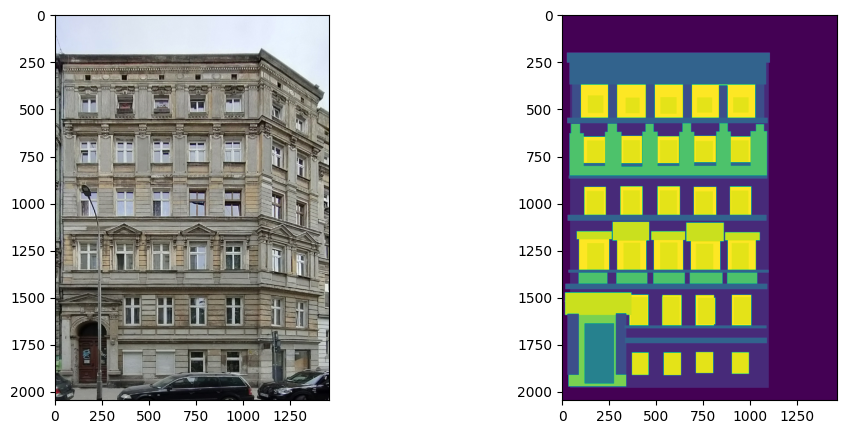

In [4]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
axes[0].imshow(some_facade_img[:,:,::-1])  # BGR -> RGB
axes[1].imshow(some_facade_mask)
plt.show()

**Drawing facade and its segmentation mask**

There is a helper function for convenient plotting:

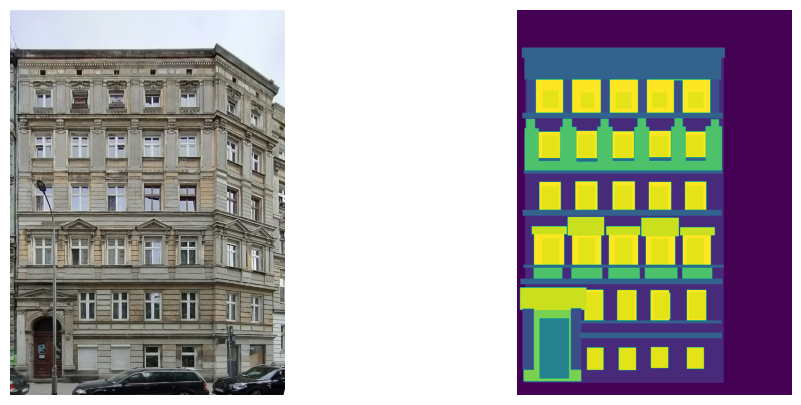

In [5]:
draw_facade_and_mask(
    img=some_facade_img,
    mask=some_facade_mask,
    show_axis=False
)

### Lattices and lattice tools

Wroface provides tools to automatically put a rectangular lattice on a facede image (using its segmentation mask)
and to perform operations on the image based on the lattice.

The class implementing lattice is `src.utils.lattice_utils.lattice.Lattice`. An object of this class represents
one facede image with added lattice. Mathemtically, a lattice is represented as a set of rectangular and
horizontal _split lines_.

For a pair: (facade image, facade mask), a lattice can be obtained as follows:

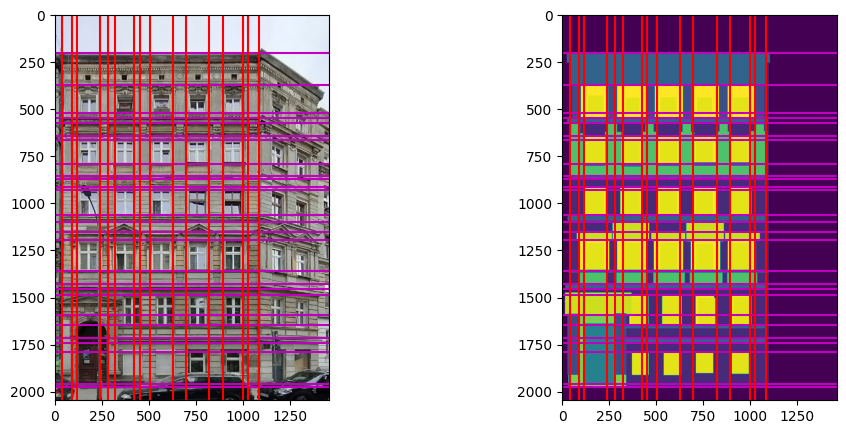

In [6]:
# get split lines
hor_lines_inds, ver_lines_inds = infer_split_lines(
    mask=some_facade_mask, dbscan_params={'eps': 15, 'min_samples': 1},
    min_change_coef=0.07
)

# create a Lattice object
lattice = Lattice.from_lines(
    img=some_facade_img, mask=some_facade_mask,
    horizontal_lines_inds=hor_lines_inds, vertical_lines_inds=ver_lines_inds
)

# plot the lattice
lattice.plot()

In the split line extraction step, the DBSCAN clustering algorithm is utilized to merge redundant
split lines.

We can nowe _crop_ the facade (i.e. remove lattice's columns and rows that contain mostly background).

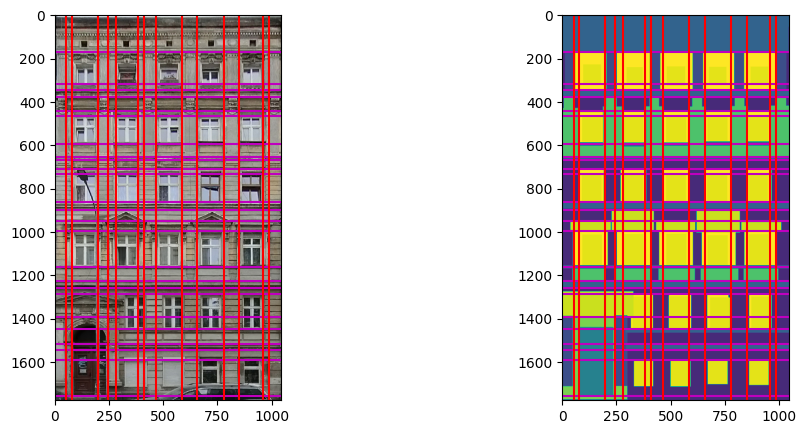

In [7]:
lattice = crop_facade(lattice, background_label=0)
lattice.plot()

Now, with the cropped facade's image and mask, we can obtain a more accurate lattice.

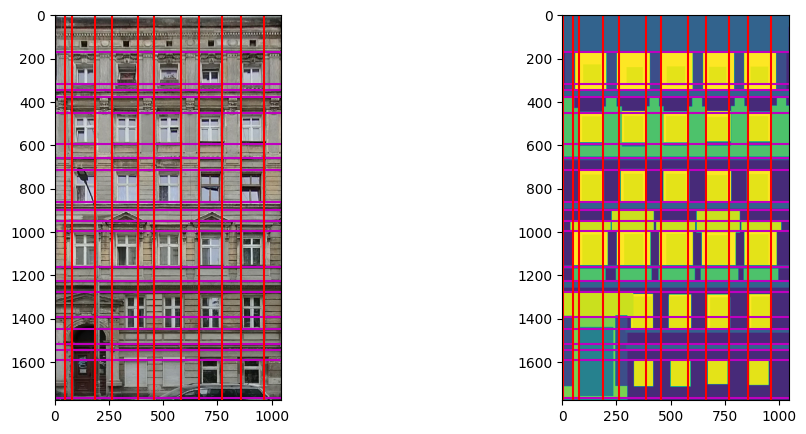

In [8]:
cropped_img, cropped_mask = lattice.assemble_lattice()  # extract image and mask from lattice

# obtain a better lattice, using cropped image and mask
hor_lines_inds, ver_lines_inds = infer_split_lines(
    mask=cropped_mask, dbscan_params={'eps': 25, 'min_samples': 1},
    min_change_coef=0.1
)
better_lattice = Lattice.from_lines(
    img=cropped_img, mask=cropped_mask,
    horizontal_lines_inds=hor_lines_inds, vertical_lines_inds=ver_lines_inds
)

better_lattice.plot()

We can index a lattice like a NumPy array - indexing produces another `Lattice` object.

In [9]:
better_lattice[2,5]

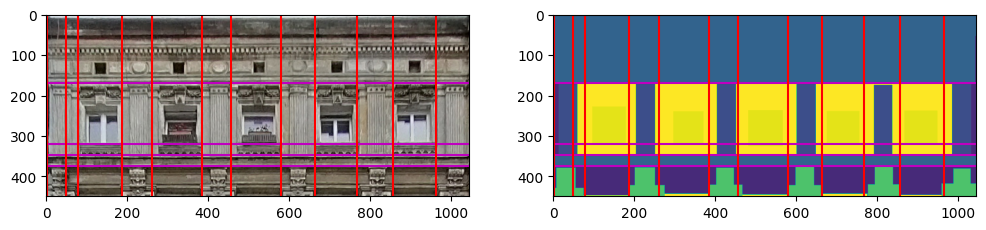

In [10]:
better_lattice[:5].plot()

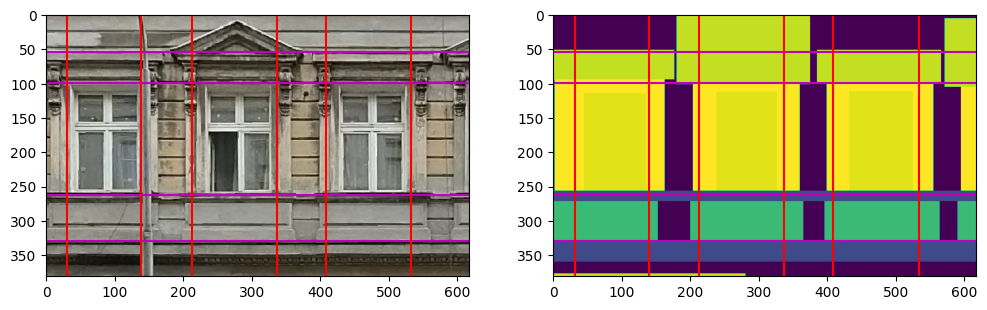

In [11]:
better_lattice[10:15, 2:9].plot()

In [12]:
better_lattice.ranges.shape

(22, 13)

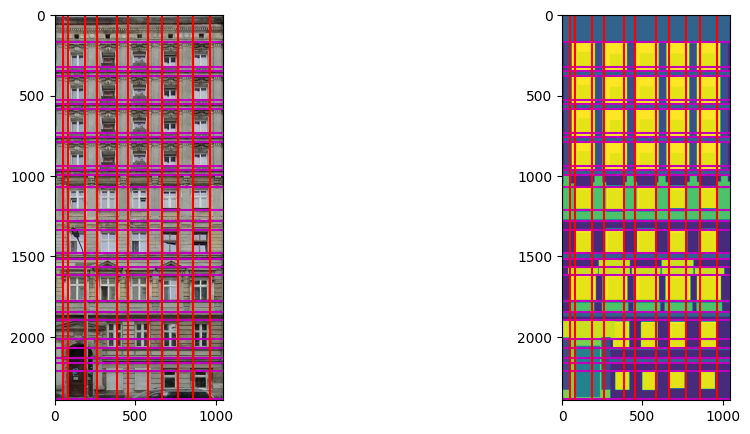

In [13]:
rows = np.array([0] + [1,2,3]*4 + list(range(4, 22)), dtype='int')
better_lattice[rows, :].plot()

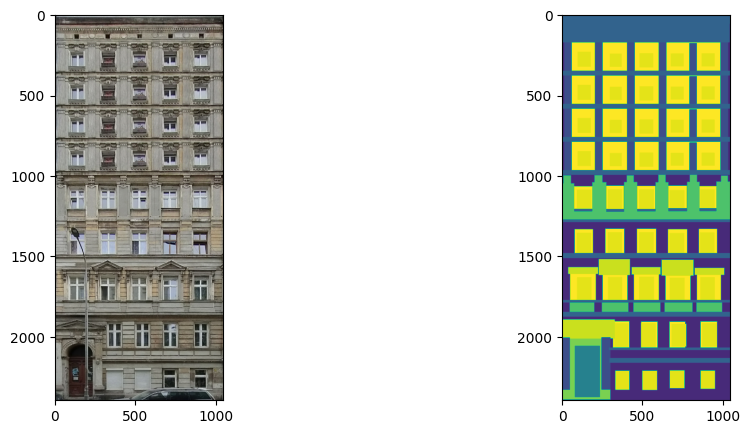

In [14]:
draw_facade_and_mask(*better_lattice[rows, :].assemble_lattice())